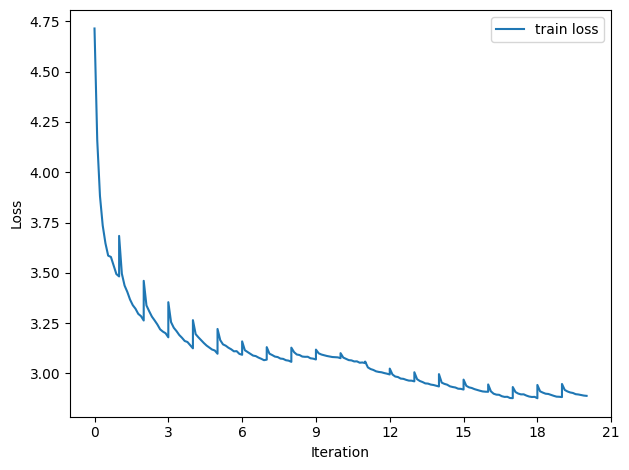

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

out_dir = Path(f"results/lithium")

t_list, loss_list = [], []

for i in range(1, 21):
    loss = np.load(out_dir / f"train-{i}_loss.npy")
    loss = np.mean(loss, axis=1)
    t_list.append(np.linspace(i - 1, i, len(loss)))
    loss_list.append(loss)

x, y = np.concatenate(t_list), np.concatenate(loss_list)

plt.figure()
plt.plot(x, y, label="train loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
ax = plt.gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.tight_layout()
plt.legend()
plt.savefig("results/train_loss.svg")
plt.show()

In [2]:
from util import *
from pit_rating import parse_pit_sgf
from pathlib import Path
import pandas as pd

out_dir = Path(f"results/pit-puct")
results = []

# PUCT vs {Random, UCT}
for i in range(1, 11):
    for j in ("random", "uct"):
        with open(out_dir / f"{j}_vs_puct-{i}" / "match.sgf") as f:
            black, white = parse_pit_sgf(f.read())
        results.append((i, j, black.inverse(), white))

df = pd.DataFrame(results, columns=["iter", "baseline", "black", "white"])
df.set_index(["iter", "baseline"], inplace=True)
df["combined"] = df["black"] + df["white"]
df

black                      white  \
iter baseline                                                         
1    random     Win: 8, Lose: 2, Draw: 0   Win: 9, Lose: 1, Draw: 0   
     uct        Win: 8, Lose: 1, Draw: 1   Win: 6, Lose: 4, Draw: 0   
2    random    Win: 10, Lose: 0, Draw: 0  Win: 10, Lose: 0, Draw: 0   
     uct        Win: 8, Lose: 1, Draw: 1  Win: 10, Lose: 0, Draw: 0   
3    random    Win: 10, Lose: 0, Draw: 0  Win: 10, Lose: 0, Draw: 0   
     uct        Win: 8, Lose: 2, Draw: 0   Win: 9, Lose: 1, Draw: 0   
4    random     Win: 9, Lose: 1, Draw: 0  Win: 10, Lose: 0, Draw: 0   
     uct        Win: 8, Lose: 2, Draw: 0   Win: 6, Lose: 3, Draw: 1   
5    random    Win: 10, Lose: 0, Draw: 0  Win: 10, Lose: 0, Draw: 0   
     uct        Win: 7, Lose: 3, Draw: 0   Win: 6, Lose: 4, Draw: 0   
6    random    Win: 10, Lose: 0, Draw: 0  Win: 10, Lose: 0, Draw: 0   
     uct        Win: 9, Lose: 1, Draw: 0   Win: 9, Lose: 1, Draw: 0   
7    random    Win: 10, Lose: 0, Draw: 0  Win: 10, Lose: 0, Draw: 0   
     uct        Win: 8, Lose: 2, Draw: 0  Win: 10, Lose: 0, Draw: 0   
8    random    Win: 10, Lose: 0, Draw: 0  Win: 10, Lose: 0, Draw: 0   
     uct        Win: 8, Lose: 2, Draw: 0  Win: 10, Lose: 0, Draw: 0   
9    random    Win: 10, Lose: 0, Draw: 0   Win: 9, Lose: 1, Draw: 0   
     uct       Win: 10, Lose: 0, Draw: 0  Win: 10, Lose: 0, Draw: 0   
10   random    Win: 10, Lose: 0, Draw: 0  Win: 10, Lose: 0, Draw: 0   
     uct        Win: 9, Lose: 1, Draw: 0  Win: 10, Lose: 0, Draw: 0   

                                combined  
iter baseline                             
1    random    Win: 17, Lose: 3, Draw: 0  
     uct       Win: 14, Lose: 5, Draw: 1  
2    random    Win: 20, Lose: 0, Draw: 0  
     uct       Win: 18, Lose: 1, Draw: 1  
3    random    Win: 20, Lose: 0, Draw: 0  
     uct       Win: 17, Lose: 3, Draw: 0  
4    random    Win: 19, Lose: 1, Draw: 0  
     uct       Win: 14, Lose: 5, Draw: 1  
5    random    Win: 20, Lose: 0, Draw: 0  
     uct       Win: 13, Lose: 7, Draw: 0  
6    random    Win: 20, Lose: 0, Draw: 0  
     uct       Win: 18, Lose: 2, Draw: 0  
7    random    Win: 20, Lose: 0, Draw: 0  
     uct       Win: 18, Lose: 2, Draw: 0  
8    random    Win: 20, Lose: 0, Draw: 0  
     uct       Win: 18, Lose: 2, Draw: 0  
9    random    Win: 19, Lose: 1, Draw: 0  
     uct       Win: 20, Lose: 0, Draw: 0  
10   random    Win: 20, Lose: 0, Draw: 0  
     uct       Win: 19, Lose: 1, Draw: 0

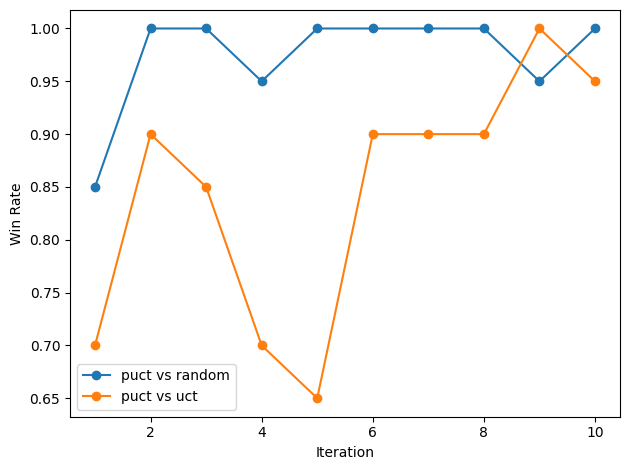

In [9]:
plt.figure()

for opponent in ("random", "uct"):
    data = df.xs(opponent, level="baseline")
    t = data.index.get_level_values("iter")
    win_rate = data["combined"].apply(lambda x: x.win_rate)
    plt.plot(t, win_rate, label=f"puct vs {opponent}", marker="o")

plt.xlabel("Iteration")
plt.ylabel("Win Rate")
plt.tight_layout()
plt.legend()
plt.savefig("results/puct_vs_baseline.svg")
plt.show()

In [8]:
from pit_rating import EloRating

elo = EloRating()
elo.load_results('results/pit-puct')

print("#players:", len(elo.players))
print("#results:", len(elo.results))

Loading results: 100%|██████████| 500/500 [00:07<00:00, 65.93it/s]

#players: 102
#results: 10000


In [5]:
import pandas as pd

# ratings = elo.elo_rating()
ratings, model = elo.elo_rating_sgd()

baseline_player, baseline_rating = "random", 0
df_rating = pd.DataFrame(ratings.items(), columns=['player', 'rating'])
df_rating.set_index('player', inplace=True)
df_rating['rating'] += baseline_rating - ratings[baseline_player]
df_rating['stats'] = df_rating.index.map(lambda x: elo.players[x].stats)
df_rating.sort_values('rating', inplace=True, ascending=False)
df_rating.to_csv('results/puct_elo_rating.csv')
df_rating

,rating,stats
player,,
puct-96,2227.435059,"Win: 102, Lose: 58, Draw: 0"
puct-93,2223.284180,"Win: 107, Lose: 72, Draw: 1"
puct-92,2196.596191,"Win: 106, Lose: 74, Draw: 0"
puct-95,2187.080078,"Win: 103, Lose: 77, Draw: 0"
puct-94,2182.268799,"Win: 98, Lose: 82, Draw: 0"
...,...,...
puct-2,561.605591,"Win: 85, Lose: 71, Draw: 4"
puct-3,547.184021,"Win: 84, Lose: 91, Draw: 5"
puct-1,329.014038,"Win: 41, Lose: 95, Draw: 4"


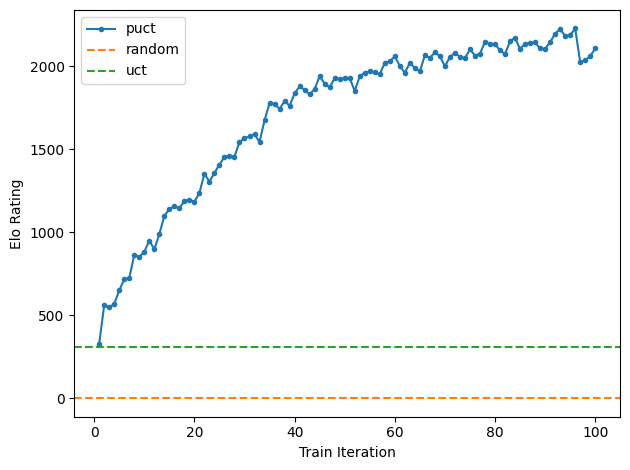

In [6]:
import matplotlib.pyplot as plt

df_puct = df_rating[df_rating.index.str.startswith('puct')].copy()
df_puct['epoch'] = df_puct.index.str.split('-').str[1].astype(int)
df_puct.sort_values('epoch', inplace=True)

plt.figure()
plt.plot(df_puct['epoch'], df_puct['rating'], marker='.', label='puct')
plt.axhline(y=df_rating.loc['random', 'rating'], color='tab:orange', linestyle='--', label='random')
plt.axhline(y=df_rating.loc['uct', 'rating'], color='tab:green', linestyle='--', label='uct')
plt.xlabel('Train Iteration')
plt.ylabel('Elo Rating')
plt.tight_layout()
plt.legend()
plt.savefig('results/puct_elo_rating.svg')

In [7]:
import torch
import torch.nn.functional as F

p1, p2 = (
    torch.tensor([elo.players[p].id], dtype=torch.long)
    for p in ("puct-5", "uct")
)
out = model((p1, p2))
out = F.softmax(out, dim=1).detach().numpy()[0]
out # (win, draw, lose)

array([0.8943884 , 0.00452955, 0.1010821 ], dtype=float32)